## Summary
### Dec 8, 2016

Looks like there are some different parameterizations people have done to different continuous variables ([see this post](https://www.kaggle.com/mariusbo/allstate-claims-severity/xgb-lb-1106-33084/discussion)). Try running their xgboost model, and averaging with some of my other models (NN).

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb

from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.cross_validation import KFold
from scipy.stats import skew, boxcox
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import itertools

In [2]:
shift = 200
COMB_FEATURE = 'cat80,cat87,cat57,cat12,cat79,cat10,cat7,cat89,cat2,cat72,' \
               'cat81,cat11,cat1,cat13,cat9,cat3,cat16,cat90,cat23,cat36,' \
               'cat73,cat103,cat40,cat28,cat111,cat6,cat76,cat50,cat5,' \
               'cat4,cat14,cat38,cat24,cat82,cat25'.split(',')

def encode(charcode):
    r = 0
    ln = len(str(charcode))
    for i in range(ln):
        r += (ord(str(charcode)[i]) - ord('A') + 1) * 26 ** (ln - i - 1)
    return r

fair_constant = 0.7
def fair_obj(preds, dtrain):
    labels = dtrain.get_label()
    x = (preds - labels)
    den = abs(x) + fair_constant
    grad = fair_constant * x / (den)
    hess = fair_constant * fair_constant / (den * den)
    return grad, hess

def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y)-shift,
                                      np.exp(yhat)-shift)
def mungeskewed(train, test, numeric_feats):
    ntrain = train.shape[0]
    test['loss'] = 0
    train_test = pd.concat((train, test)).reset_index(drop=True)
    skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
    skewed_feats = skewed_feats[skewed_feats > 0.25]
    skewed_feats = skewed_feats.index

    for feats in skewed_feats:
        train_test[feats] = train_test[feats] + 1
        train_test[feats], lam = boxcox(train_test[feats])
    return train_test, ntrain

In [3]:
import os
import matplotlib.pyplot as plt
%matplotlib inline


loc = '/Users/elena/Documents/Kaggle/Allstate/data/'
train = pd.read_csv(os.path.join(loc,'train.csv'))
#train.drop('id',axis=1,inplace=True)

test = pd.read_csv(os.path.join(loc,'test.csv'))
ids = test['id']
#test.drop('id',axis=1,inplace=True)

submission = pd.read_csv(os.path.join(loc,"sample_submission.csv"))

In [4]:
numeric_feats = [x for x in train.columns[1:-1] if 'cont' in x]
categorical_feats = [x for x in train.columns[1:-1] if 'cat' in x]
train_test, ntrain = mungeskewed(train, test, numeric_feats)

In [5]:
# taken from Vladimir's script (https://www.kaggle.com/iglovikov/allstate-claims-severity/xgb-1114)
for column in list(train.select_dtypes(include=['object']).columns):
    if train[column].nunique() != test[column].nunique():
        set_train = set(train[column].unique())
        set_test = set(test[column].unique())
        remove_train = set_train - set_test
        remove_test = set_test - set_train

        remove = remove_train.union(remove_test)


        def filter_cat(x):
            if x in remove:
                return np.nan
            return x


        train_test[column] = train_test[column].apply(lambda x: filter_cat(x), 1)

In [6]:
# taken from Ali's script (https://www.kaggle.com/aliajouz/allstate-claims-severity/singel-model-lb-1117)
train_test["cont1"] = np.sqrt(preprocessing.minmax_scale(train_test["cont1"]))
train_test["cont4"] = np.sqrt(preprocessing.minmax_scale(train_test["cont4"]))
train_test["cont5"] = np.sqrt(preprocessing.minmax_scale(train_test["cont5"]))
train_test["cont8"] = np.sqrt(preprocessing.minmax_scale(train_test["cont8"]))
train_test["cont10"] = np.sqrt(preprocessing.minmax_scale(train_test["cont10"]))
train_test["cont11"] = np.sqrt(preprocessing.minmax_scale(train_test["cont11"]))
train_test["cont12"] = np.sqrt(preprocessing.minmax_scale(train_test["cont12"]))

train_test["cont6"] = np.log(preprocessing.minmax_scale(train_test["cont6"]) + 0000.1)
train_test["cont7"] = np.log(preprocessing.minmax_scale(train_test["cont7"]) + 0000.1)
train_test["cont9"] = np.log(preprocessing.minmax_scale(train_test["cont9"]) + 0000.1)
train_test["cont13"] = np.log(preprocessing.minmax_scale(train_test["cont13"]) + 0000.1)
train_test["cont14"] = (np.maximum(train_test["cont14"] - 0.179722, 0) / 0.665122) ** 0.25

In [7]:
for comb in itertools.combinations(COMB_FEATURE, 2):
    feat = comb[0] + "_" + comb[1]
    train_test[feat] = train_test[comb[0]] + train_test[comb[1]]
    train_test[feat] = train_test[feat].apply(encode)
    print('Combining Columns:', feat)


for col in categorical_feats:
    print('Analyzing Column:', col)
    train_test[col] = train_test[col].apply(encode)

print(train_test[categorical_feats])

('Combining Columns:', 'cat80_cat87')
('Combining Columns:', 'cat80_cat57')
('Combining Columns:', 'cat80_cat12')
('Combining Columns:', 'cat80_cat79')
('Combining Columns:', 'cat80_cat10')
('Combining Columns:', 'cat80_cat7')
('Combining Columns:', 'cat80_cat89')
('Combining Columns:', 'cat80_cat2')
('Combining Columns:', 'cat80_cat72')
('Combining Columns:', 'cat80_cat81')
('Combining Columns:', 'cat80_cat11')
('Combining Columns:', 'cat80_cat1')
('Combining Columns:', 'cat80_cat13')
('Combining Columns:', 'cat80_cat9')
('Combining Columns:', 'cat80_cat3')
('Combining Columns:', 'cat80_cat16')
('Combining Columns:', 'cat80_cat90')
('Combining Columns:', 'cat80_cat23')
('Combining Columns:', 'cat80_cat36')
('Combining Columns:', 'cat80_cat73')
('Combining Columns:', 'cat80_cat103')
('Combining Columns:', 'cat80_cat40')
('Combining Columns:', 'cat80_cat28')
('Combining Columns:', 'cat80_cat111')
('Combining Columns:', 'cat80_cat6')
('Combining Columns:', 'cat80_cat76')
('Combining Colu

In [8]:
test.columns

Index([u'id', u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7',
       u'cat8', u'cat9',
       ...
       u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11', u'cont12',
       u'cont13', u'cont14', u'loss'],
      dtype='object', length=132)

In [9]:
ss = StandardScaler()
train_test[numeric_feats] = \
    ss.fit_transform(train_test[numeric_feats].values)

train = train_test.iloc[:ntrain, :].copy()
test = train_test.iloc[ntrain:, :].copy()

print('\nMedian Loss:', train.loss.median())
print('Mean Loss:', train.loss.mean())

ids = pd.read_csv(os.path.join(loc,'test.csv'))['id']
train_y = np.log(train['loss'] + shift)
train_x = train.drop(['loss','id'], axis=1)
test_x = test.drop(['loss','id'], axis=1)

n_folds = 10
cv_sum = 0
early_stopping = 100
fpred = []
xgb_rounds = []

d_train_full = xgb.DMatrix(train_x, label=train_y)
d_test = xgb.DMatrix(test_x)

kf = KFold(train.shape[0], n_folds=n_folds)
for i, (train_index, test_index) in enumerate(kf):
    print('\n Fold %d' % (i+1))
    X_train, X_val = train_x.iloc[train_index], train_x.iloc[test_index]
    y_train, y_val = train_y.iloc[train_index], train_y.iloc[test_index]

    rand_state = 2016

    params = {
        'seed': 0,
        'colsample_bytree': 0.7,
        'silent': 1,
        'subsample': 0.7,
        'learning_rate': 0.03,
        'objective': 'reg:linear',
        'max_depth': 12,
        'min_child_weight': 100,
        'booster': 'gbtree'}

    d_train = xgb.DMatrix(X_train, label=y_train)
    d_valid = xgb.DMatrix(X_val, label=y_val)
    watchlist = [(d_train, 'train'), (d_valid, 'eval')]

    clf = xgb.train(params,
                    d_train,
                    100000,
                    watchlist,
                    early_stopping_rounds=50,
                    obj=fair_obj,
                    feval=xg_eval_mae)

    xgb_rounds.append(clf.best_iteration)
    scores_val = clf.predict(d_valid, ntree_limit=clf.best_ntree_limit)
    cv_score = mean_absolute_error(np.exp(y_val), np.exp(scores_val))
    print('eval-MAE: %.6f' % cv_score)
    y_pred = np.exp(clf.predict(d_test, ntree_limit=clf.best_ntree_limit)) - shift

    if i > 0:
        fpred = pred + y_pred
    else:
        fpred = y_pred
    pred = fpred
    cv_sum = cv_sum + cv_score

mpred = pred / n_folds
score = cv_sum / n_folds
print('Average eval-MAE: %.6f' % score)
n_rounds = int(np.mean(xgb_rounds))

('\nMedian Loss:', 2115.5699999999997)
('Mean Loss:', 3037.3376856699792)

 Fold 1
[0]	train-mae:3216.67	eval-mae:3225
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 50 rounds.
[1]	train-mae:3174.86	eval-mae:3183.17
[2]	train-mae:3113.79	eval-mae:3122.06
[3]	train-mae:3040.82	eval-mae:3049.05
[4]	train-mae:2961.02	eval-mae:2969.14
[5]	train-mae:2878.43	eval-mae:2886.39
[6]	train-mae:2796.59	eval-mae:2804.27
[7]	train-mae:2716.32	eval-mae:2723.6
[8]	train-mae:2638.33	eval-mae:2645.32
[9]	train-mae:2563.26	eval-mae:2569.95
[10]	train-mae:2491.25	eval-mae:2497.67
[11]	train-mae:2422.26	eval-mae:2428.5
[12]	train-mae:2356.73	eval-mae:2362.88
[13]	train-mae:2294.84	eval-mae:2300.94
[14]	train-mae:2236.36	eval-mae:2242.65
[15]	train-mae:2181.04	eval-mae:2187.58
[16]	train-mae:2127.93	eval-mae:2134.56
[17]	train-mae:2077.75	eval-mae:2084.56
[18]	train-mae:2030.34	eval-mae:2037.06
[19]	train-mae:1985.72	eval-mae

In [10]:
result = pd.DataFrame(mpred, columns=['loss'])
result["id"] = ids

result.to_csv(os.path.join(loc,'xgboost2.csv'),index=False)
result.head()

,loss,id
0,1575.372681,4
1,1941.980225,6
2,10236.970703,9
3,6666.147461,12
4,780.329224,15


## Compare to NN and first XGB

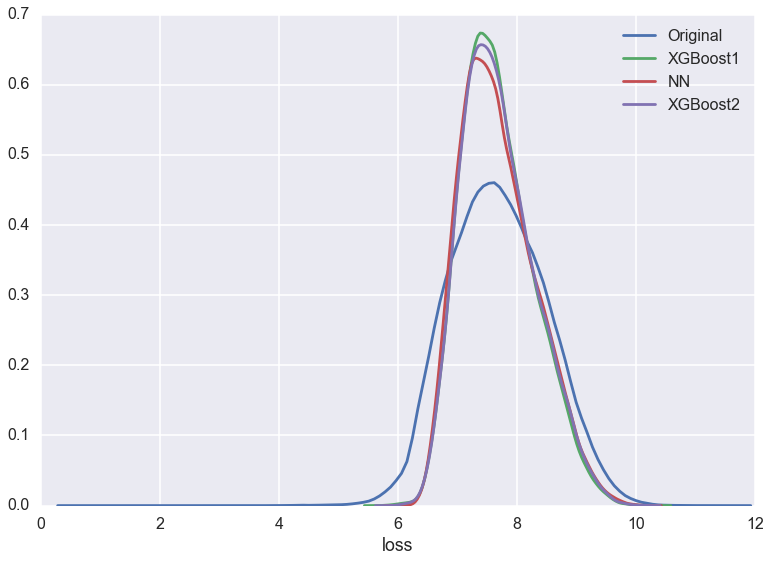

In [11]:
orig_xgb = pd.read_csv(os.path.join(loc,'xgboost1.csv'))
orig_nn = pd.read_csv(os.path.join(loc,'submission_keras.csv'))

orig_loss = pd.read_csv(os.path.join(loc,'train.csv'))

import seaborn as sns
sns.set_context('poster')
sns.distplot(np.log1p(orig_loss['loss']),hist=False,label='Original')
sns.distplot(np.log1p(orig_xgb['loss']),hist=False,label='XGBoost1')
sns.distplot(np.log1p(orig_nn['loss']),hist=False,label='NN')
sns.distplot(np.log1p(result['loss']),hist=False,label='XGBoost2')
plt.legend()